In [ ]:
import gymnasium as gym
import gymnasium_robotics

gym.register_envs(gymnasium_robotics)

env = gym.make("FetchPickAndPlaceDense-v3")
#env = gym.make("FetchPickAndPlace-v3")  # sin render_mode
# env = gym.make("FetchPickAndPlace-v3", render_mode="human")  # con render_mode
obs, info = env.reset()

print("Observación:", obs.keys())
print("Espacio de acción:", env.action_space)
print("Espacio de observación:", env.observation_space)

Observación: dict_keys(['observation', 'achieved_goal', 'desired_goal'])
Espacio de acción: Box(-1.0, 1.0, (4,), float32)
Espacio de observación: Dict('achieved_goal': Box(-inf, inf, (3,), float64), 'desired_goal': Box(-inf, inf, (3,), float64), 'observation': Box(-inf, inf, (25,), float64))


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, action_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.mean = nn.Linear(64, action_dim)
        self.log_std = nn.Parameter(torch.zeros(action_dim))

    def forward(self, x):
        x = self.fc(x)
        return self.mean(x), self.log_std.expand_as(self.mean(x))

    def act(self, state):
        state = torch.tensor(state, dtype=torch.float32).to(device)
        mean, log_std = self.forward(state)
        std = torch.exp(log_std)
        dist = torch.distributions.Normal(mean, std)
        action = dist.sample()
        log_prob = dist.log_prob(action).sum()
        return action.cpu().detach().numpy(), log_prob


In [ ]:

class CriticNetwork(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.net(x)


In [4]:
def actor_critic(env, policy, critic, policy_optimizer, critic_optimizer, episodes=500, gamma=0.99):
    rewards_history = []

    for episode in range(episodes):
        state, _ = env.reset()
        state = np.concatenate([state["observation"], state["desired_goal"]])

        log_probs = []
        values = []
        rewards = []

        for _ in range(100):
            state_tensor = torch.tensor(state, dtype=torch.float32).to(device)
            value = critic(state_tensor)
            action, log_prob = policy.act(state)

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_state = np.concatenate([next_state["observation"], next_state["desired_goal"]])

            log_probs.append(log_prob)
            values.append(value)
            rewards.append(reward)

            state = next_state
            if done:
                break

        # Calcular retornos y ventajas
        returns = []
        G = 0
        for r in reversed(rewards):
            G = r + gamma * G
            returns.insert(0, G)
        returns = torch.tensor(returns, dtype=torch.float32).to(device)
        values = torch.stack(values).squeeze()
        advantages = returns - values.detach()

        # Pérdida actor
        policy_loss = [ -log_prob * advantage for log_prob, advantage in zip(log_probs, advantages)]
        policy_loss = torch.stack(policy_loss).sum()

        # Pérdida crítico
        critic_loss = nn.MSELoss()(values, returns)

        # Optimización
        policy_optimizer.zero_grad()
        policy_loss.backward()
        policy_optimizer.step()

        critic_optimizer.zero_grad()
        critic_loss.backward()
        critic_optimizer.step()

        rewards_history.append(sum(rewards))
        if episode % 10 == 0:
            print(f"Ep {episode}: Recompensa total = {sum(rewards):.2f}")

    return rewards_history


In [5]:
import gymnasium as gym
import gymnasium_robotics

# Registrar y crear entorno
gym.register_envs(gymnasium_robotics)
env = gym.make("FetchPickAndPlaceDense-v3")

obs_dim = env.observation_space["observation"].shape[0]
goal_dim = env.observation_space["desired_goal"].shape[0]
action_dim = env.action_space.shape[0]

input_dim = obs_dim + goal_dim

# Instancias
policy = PolicyNetwork(input_dim, action_dim).to(device)
critic = CriticNetwork(input_dim).to(device)

policy_optimizer = optim.Adam(policy.parameters(), lr=1e-3)
critic_optimizer = optim.Adam(critic.parameters(), lr=1e-3)

# Entrenar
historia_ac = actor_critic(env, policy, critic, policy_optimizer, critic_optimizer, episodes=500)


Ep 0: Recompensa total = -21.20
Ep 10: Recompensa total = -21.03
Ep 20: Recompensa total = -43.23
Ep 30: Recompensa total = -25.95
Ep 40: Recompensa total = -23.50
Ep 50: Recompensa total = -25.45
Ep 60: Recompensa total = -43.19
Ep 70: Recompensa total = -20.91
Ep 80: Recompensa total = -21.93
Ep 90: Recompensa total = -22.28
Ep 100: Recompensa total = -25.15
Ep 110: Recompensa total = -42.82
Ep 120: Recompensa total = -21.30
Ep 130: Recompensa total = -41.48
Ep 140: Recompensa total = -41.62
Ep 150: Recompensa total = -24.64
Ep 160: Recompensa total = -22.46
Ep 170: Recompensa total = -23.03
Ep 180: Recompensa total = -44.17
Ep 190: Recompensa total = -21.37
Ep 200: Recompensa total = -43.50
Ep 210: Recompensa total = -37.52
Ep 220: Recompensa total = -26.36
Ep 230: Recompensa total = -26.57
Ep 240: Recompensa total = -25.21
Ep 250: Recompensa total = -39.33
Ep 260: Recompensa total = -28.86
Ep 270: Recompensa total = -24.79
Ep 280: Recompensa total = -21.34
Ep 290: Recompensa total 

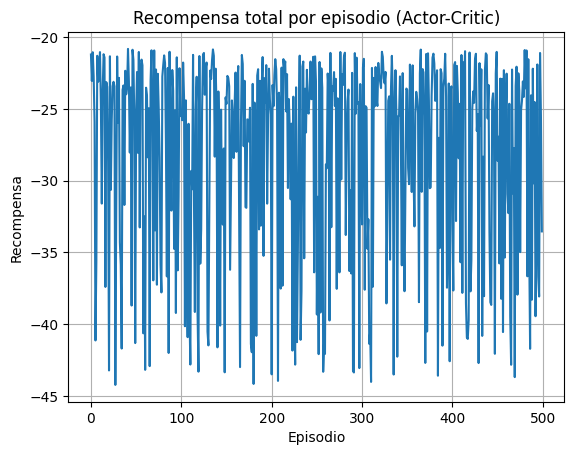

In [6]:
plt.plot(historia_ac)
plt.title("Recompensa total por episodio (Actor-Critic)")
plt.xlabel("Episodio")
plt.ylabel("Recompensa")
plt.grid(True)
plt.show()
